In [1]:
import nltk

In [2]:
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [4]:
data = pd.read_csv('data.csv')

In [5]:
data.dropna(inplace=True)

In [6]:
data.drop(['Unnamed: 0','Upvote_ratio'], axis=1, inplace=True)

Title word count lengths: 
 Min: 4 
 Max: 56 
 Average: 12.79476861167002


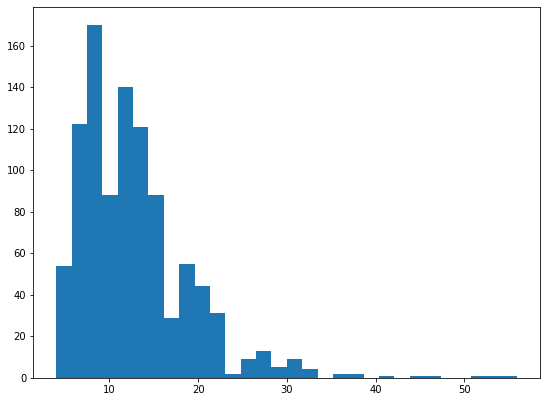

In [7]:
plt.figure(figsize=(20,15))
plt.subplot(221)
title_word_lengths = [len(str(data.Title.iloc[i]).split(' ')) for i in range(len(data))]
max_title_word_length = max(title_word_lengths)
min_title_word_length = min(title_word_lengths)
average_title_word_length = sum(title_word_lengths)/len(title_word_lengths)
plt.hist(title_word_lengths, bins = 30)
print('Title word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_title_word_length, max_title_word_length, average_title_word_length))


In [8]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_preprocess(text):
    text = re.sub(r'[^\w\s]', '', text) 
    l_text = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    stem_words = [stemmer.stem(w) for w in l_text]
    lemma_words = [lemmatizer.lemmatize(w) for w in l_text]

    return " ".join(lemma_words)

data['Title'] = data['Title'].map(lambda com : text_preprocess(com))

In [9]:
data.head()

,Title,Score,Gilded,Over_18,Number_of_Comments,neg,neu,pos,compound
0,whats fcked thing saw sleepover,40112,1,True,11626,0.000,1.000,0.000,0.0000
1,men reddit question regarding woman anatomy,3696,0,False,4944,0.098,0.902,0.000,-0.0772
2,cinematic death best oompa loompa song,4213,0,False,711,0.228,0.526,0.246,0.0772
3,fun fact,77810,0,False,33082,0.351,0.649,0.000,-0.4023
4,apart accent tell british,6295,0,False,6408,0.000,1.000,0.000,0.0000


In [10]:
i = 0

predicted_value = []

while i<len(data):
  if (data.loc[i]['compound'] >= 0.5):
    predicted_value.append('positive')
    i = i+1

  elif (data.loc[i]['compound'] >= 0) & (data.loc[i]['compound'] <= 0.5):
    predicted_value.append('neutral')
    i = i+1

  elif (data.loc[i]['compound'] <= 0):
    predicted_value.append('negative')
    i = i+1

In [11]:
data['Predicted_value'] = predicted_value

In [12]:
data.head()

,Title,Score,Gilded,Over_18,Number_of_Comments,neg,neu,pos,compound,Predicted_value
0,whats fcked thing saw sleepover,40112,1,True,11626,0.000,1.000,0.000,0.0000,neutral
1,men reddit question regarding woman anatomy,3696,0,False,4944,0.098,0.902,0.000,-0.0772,negative
2,cinematic death best oompa loompa song,4213,0,False,711,0.228,0.526,0.246,0.0772,neutral
3,fun fact,77810,0,False,33082,0.351,0.649,0.000,-0.4023,negative
4,apart accent tell british,6295,0,False,6408,0.000,1.000,0.000,0.0000,neutral


In [13]:
data.drop(['neg', 'neu', 'pos', 'compound'], axis=1, inplace=True)

In [14]:
X = data.drop(['Score'], axis=1)
y = data['Score']

In [15]:
lengths = max([len(x) for x in X.Title])
lengths


160

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train["Title"])

In [18]:
train_title = tokenizer.texts_to_sequences(X_train["Title"])
test_title = tokenizer.texts_to_sequences(X_test["Title"])

vocab_size = len(tokenizer.word_index) + 1

In [19]:
indixes = tokenizer.word_index
tokens = {k:[indixes[k]] for k in indixes}
df_tokens = pd.DataFrame(tokens)
df_tokens.to_csv('tokens.csv', header=True, index=False)

In [20]:
maxlen = 300

train_title = pad_sequences(train_title, padding='post', maxlen=maxlen)
test_title = pad_sequences(test_title, padding='post', maxlen=maxlen)

In [21]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [22]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
df = pd.DataFrame(data=embedding_matrix.astype(float))
df.to_csv('embedding.csv', sep=' ', header=True, float_format='%.2f', index=False)

In [24]:
train_new = {}
for i, sentence in enumerate(train_title):
    vectors = []
    for n in sentence:
        vectors.append(embedding_matrix[n])
    train_new[i] = vectors

In [25]:
test_new = {}
for i, sentence in enumerate(test_title):
    vectors = []
    for n in sentence:
        vectors.append(embedding_matrix[n])
    test_new[i] = vectors

In [26]:
X_train_df = []
for key in train_new:
    arr = np.array(train_new[key])
    X_train_df.append(np.mean(arr, axis=0))

In [27]:
X_test_df = []
for key in test_new:
    arr = np.array(test_new[key])
    X_test_df.append(np.mean(arr, axis=0))

In [28]:
X_train_df = pd.DataFrame(np.array(X_train_df))
X_test_df = pd.DataFrame(np.array(X_test_df))

In [29]:
from sklearn.preprocessing import OneHotEncoder

categories = ['Over_18', 'Predicted_value']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[categories])
pickle.dump(enc, open('encoding.pkl','wb'))

In [30]:
col_names = [j for sub in enc.categories_ for j in sub] 

In [31]:
col_names

[False, True, 'negative', 'neutral', 'positive']

In [32]:
train_encoded = enc.transform(X_train[categories])
test_encoded = enc.transform(X_test[categories])

In [33]:
X_train.drop(["Title", 'Over_18', 'Predicted_value'], axis=1, inplace=True)
X_test.drop(["Title", 'Over_18', 'Predicted_value'], axis=1, inplace=True)

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [35]:
train = pd.DataFrame(train_encoded.todense(), columns=col_names)
test = pd.DataFrame(test_encoded.todense(), columns=col_names)

In [36]:
train.head()

,False,True,negative,neutral,positive
0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0


In [37]:
X_train = pd.concat([X_train, X_train_df, train], axis=1)
X_test = pd.concat([X_test, X_test_df, test], axis=1)

In [38]:
X_train.head()

,Gilded,Number_of_Comments,0,1,2,3,4,5,6,7,...,95,96,97,98,99,False,True,negative,neutral,positive
0,0,0,-0.001510,0.006157,0.001292,-0.003419,-0.006412,0.017545,-0.007559,0.000912,...,-0.013040,-0.007526,-0.010070,0.014180,0.007112,1.0,0.0,0.0,1.0,0.0
1,0,583,-0.002060,0.000359,0.005241,-0.001344,-0.005016,0.004188,0.002240,-0.001607,...,0.002904,-0.000920,-0.004743,-0.000284,-0.000594,1.0,0.0,0.0,1.0,0.0
2,0,28,0.000205,0.000067,0.004481,-0.001433,-0.000827,0.005631,-0.000609,-0.002339,...,0.000612,-0.003447,-0.001806,-0.000439,0.006107,1.0,0.0,0.0,0.0,1.0
3,0,6,-0.000765,0.003307,0.000377,0.003438,0.000818,-0.000574,-0.000413,-0.001568,...,-0.003213,0.000109,-0.005211,0.001439,-0.000141,1.0,0.0,0.0,1.0,0.0
4,0,13,0.006772,-0.002343,0.002326,-0.005693,-0.011529,0.005797,-0.011139,0.005344,...,-0.000434,-0.005192,0.001533,-0.000589,0.006516,1.0,0.0,1.0,0.0,0.0


In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

Linear Regression

In [40]:
lm=LinearRegression()   
lm = lm.fit(X_train,y_train)

#Traindata Predictions
train_pred = lm.predict(X_train)

#testdata predictions
test_pred = lm.predict(X_test)


RMSE_test = np.sqrt(mean_squared_error(y_test, test_pred))
RMSE_train= np.sqrt(mean_squared_error(y_train,train_pred))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',lm.score(X_train, y_train))
print('RSquared value on test:',lm.score(X_test, y_test))

RMSE TrainingData =  446.9455379850263
RMSE TestData =  2465.504079400032
--------------------------------------------------
RSquared value on train: 0.984641960924507
RSquared value on test: 0.8001890577292178


Random Forest Regression

In [41]:
RF=RandomForestRegressor(n_jobs=-1)
RF.fit(X_train,y_train)

#predicting train
train_preds1=RF.predict(X_train)
#predicting on test
test_preds1=RF.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds1)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds1)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',RF.score(X_train, y_train))
print('RSquared value on test:',RF.score(X_test, y_test))

RMSE TrainingData =  1126.6515135596312
RMSE TestData =  3511.579929086345
--------------------------------------------------
RSquared value on train: 0.9024098994794144
RSquared value on test: 0.5946660946077149


In [42]:
RF=RandomForestRegressor(n_jobs=-1)
RF.fit(X_train,y_train)

pickle.dump(RF, open('random.pkl','wb'))

K Nearest Neighbors

In [43]:
knn=KNeighborsRegressor()
knn.fit(X_train,y_train)

#predicting train
train_preds2=knn.predict(X_train)
#predicting on test
test_preds2=knn.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds2)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds2)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',knn.score(X_train, y_train))
print('RSquared value on test:',knn.score(X_test, y_test))

RMSE TrainingData =  2486.168779089787
RMSE TestData =  4775.6377781444235
--------------------------------------------------
RSquared value on train: 0.5247875905145564
RSquared value on test: 0.25032923472228163
